<a href="https://colab.research.google.com/github/engmariamahmed04/NTI-ML-tasks/blob/main/Final_Project_Nti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# classification part :

In [ ]:
!pip install xgboost --quiet
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/cybersecurity_intrusion_data.csv')


In [ ]:
df.drop(columns=['session_id'], inplace=True)


In [ ]:
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [ ]:
X = df.drop('attack_detected', axis=1)
y = df['attack_detected']


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
voting = VotingClassifier(estimators=[
    ('lr', models['Logistic Regression']),
    ('dt', models['Decision Tree']),
    ('rf', models['Random Forest']),
    ('xgb', models['XGBoost']),
], voting='soft')
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
y_proba = voting.predict_proba(X_test)[:, 1]

results['Voting Classifier'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
    'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
    'F1-Score': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],
    'ROC-AUC': roc_auc_score(y_test, y_proba)
}

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:57:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
results_df = pd.DataFrame(results).T
print("\n📊 Model Comparison:\n")
print(results_df)



📊 Model Comparison:

                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.745283   0.748042  0.661663  0.702206  0.800309
Decision Tree        0.833333   0.814220  0.819861  0.817031  0.832196
Random Forest        0.894654   0.995529  0.771363  0.869226  0.890391
SVM                  0.881027   0.962373  0.767898  0.854207  0.882045
XGBoost              0.890461   0.969957  0.782910  0.866454  0.896321
Voting Classifier    0.885220   0.954993  0.784065  0.861129  0.890463


In [ ]:
!pip install gradio --quiet
import gradio as gr
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('/content/cybersecurity_intrusion_data.csv')
df.drop(columns=['session_id'], inplace=True)

# Encode categorical
cat_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Split and train model
X = df.drop('attack_detected', axis=1)
y = df['attack_detected']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Prediction function
def predict_intrusion(network_packet_size, protocol_type, login_attempts,
                      session_duration, encryption_used, ip_reputation_score,
                      failed_logins, browser_type, unusual_time_access):

    input_dict = {
        'network_packet_size': int(network_packet_size),
        'protocol_type': encoders['protocol_type'].transform([protocol_type])[0],
        'login_attempts': int(login_attempts),
        'session_duration': float(session_duration),
        'encryption_used': encoders['encryption_used'].transform([encryption_used])[0],
        'ip_reputation_score': float(ip_reputation_score),
        'failed_logins': int(failed_logins),
        'browser_type': encoders['browser_type'].transform([browser_type])[0],
        'unusual_time_access': int(unusual_time_access)
    }

    input_df = pd.DataFrame([input_dict])
    input_scaled = scaler.transform(input_df)
    pred = model.predict(input_scaled)[0]
    return "🔴 Intrusion Detected" if pred == 1 else "🟢 Normal Session"

#  Gradio UI
protocols = list(encoders['protocol_type'].classes_)
encryptions = list(encoders['encryption_used'].classes_)
browsers = list(encoders['browser_type'].classes_)

ui = gr.Interface(
    fn=predict_intrusion,
    inputs=[
        gr.Number(label="Network Packet Size"),
        gr.Dropdown(protocols, label="Protocol Type"),
        gr.Number(label="Login Attempts"),
        gr.Number(label="Session Duration (s)"),
        gr.Dropdown(encryptions, label="Encryption Used"),
        gr.Number(label="IP Reputation Score (0-1)"),
        gr.Number(label="Failed Logins"),
        gr.Dropdown(browsers, label="Browser Type"),
        gr.Radio([0, 1], label="Unusual Time Access?")
    ],
    outputs="text",
    title=" Cybersecurity Intrusion Detection",
    description="Enter session details to detect potential intrusions.",
    theme="default"
)

ui.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5e06ff0712540307e6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**unsupervised part :**

---



---



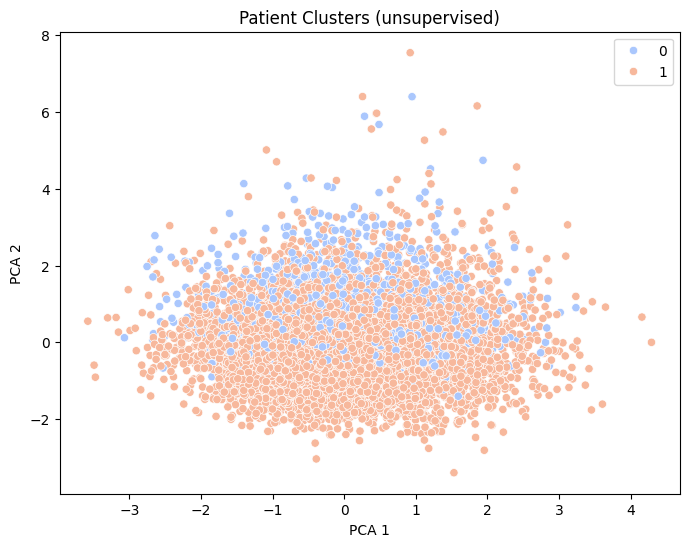

attack_detected     0     1
Cluster                    
0                 776   654
1                4497  3610

Cluster 1 stats:
       network_packet_size  login_attempts  session_duration  \
count          8107.000000     8107.000000       8107.000000   
mean            500.535216        4.026027        788.474116   
std             198.509854        1.967272        781.599399   
min              64.000000        1.000000          0.500000   
25%             366.000000        3.000000        231.152008   
50%             497.000000        4.000000        553.463342   
75%             634.000000        5.000000       1102.109157   
max            1285.000000       13.000000       7190.392213   

       ip_reputation_score  failed_logins  unusual_time_access  \
count          8107.000000    8107.000000               8107.0   
mean              0.331572       1.515110                  0.0   
std               0.177519       1.030314                  0.0   
min               0.002497   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load dataset from raw
df = pd.read_csv("/content/cybersecurity_intrusion_data.csv")

df_unsupervised = df.drop(columns=['session_id', 'attack_detected'])

df_unsupervised['encryption_used'] = df_unsupervised['encryption_used'].fillna(df_unsupervised['encryption_used'].mode()[0])

cat_cols = df_unsupervised.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df_unsupervised[col] = le.fit_transform(df_unsupervised[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_unsupervised)


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='coolwarm')
plt.title("Patient Clusters (unsupervised)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

print(pd.crosstab(df['Cluster'], df['attack_detected']))


for c in df['Cluster'].unique():
    print(f"\nCluster {c} stats:")
    print(df[df['Cluster'] == c].describe())

In [ ]:
!pip install gradio --quiet

import gradio as gr
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv('/content/cybersecurity_intrusion_data.csv')
df.drop(columns=['session_id'], inplace=True)

cat_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop('attack_detected', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_model = IsolationForest(contamination=0.1, random_state=42)
iso_model.fit(X_scaled)

def detect_intrusion(network_packet_size, protocol_type, login_attempts,
                     session_duration, encryption_used, ip_reputation_score,
                     failed_logins, browser_type, unusual_time_access):

    input_dict = {
        'network_packet_size': int(network_packet_size),
        'protocol_type': encoders['protocol_type'].transform([protocol_type])[0],
        'login_attempts': int(login_attempts),
        'session_duration': float(session_duration),
        'encryption_used': encoders['encryption_used'].transform([encryption_used])[0],
        'ip_reputation_score': float(ip_reputation_score),
        'failed_logins': int(failed_logins),
        'browser_type': encoders['browser_type'].transform([browser_type])[0],
        'unusual_time_access': int(unusual_time_access)
    }

    input_df = pd.DataFrame([input_dict])
    input_scaled = scaler.transform(input_df)
    prediction = iso_model.predict(input_scaled)[0]

    return "🔴 Intrusion Detected" if prediction == -1 else "🟢 Normal Session"



protocols = list(encoders['protocol_type'].classes_)
encryptions = list(encoders['encryption_used'].classes_)
browsers = list(encoders['browser_type'].classes_)

ui = gr.Interface(
    fn=detect_intrusion,
    inputs=[
        gr.Number(label="Network Packet Size"),
        gr.Dropdown(protocols, label="Protocol Type"),
        gr.Number(label="Login Attempts"),
        gr.Number(label="Session Duration (s)"),
        gr.Dropdown(encryptions, label="Encryption Used"),
        gr.Number(label="IP Reputation Score (0.0 - 1.0)"),
        gr.Number(label="Failed Logins"),
        gr.Dropdown(browsers, label="Browser Type"),
        gr.Radio([0, 1], label="Unusual Time Access?")
    ],
    outputs="text",
    title="Unsupervised Intrusion Detection",
    description="Enter session data to detect anomalies using Isolation Forest (unsupervised)."
)

# Launch UI
ui.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6ac10a6ac6938ebb8a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


regression part


In [ ]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess the dataset
df = pd.read_csv("water_potability.csv")

# Drop the target column from features
features = df.drop('Trihalomethanes', axis=1)
target = df['Trihalomethanes']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(features)
y = target.fillna(target.mean())

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)

#  prediction function for Gradio
def predict_trihalomethanes(ph, hardness, solids, chloramines, sulfate, conductivity, organic_carbon, turbidity, potability):
    input_data = pd.DataFrame([[ph, hardness, solids, chloramines, sulfate,
                                conductivity, organic_carbon, turbidity, potability]],
                              columns=features.columns)
    input_data = imputer.transform(input_data)
    prediction = model.predict(input_data)[0]
    return round(prediction, 2)

#  Gradio interface
inputs = [
    gr.Slider(0.0, 14.0, value=7.0, label="pH"),
    gr.Slider(50.0, 300.0, value=150.0, label="Hardness"),
    gr.Slider(5000.0, 50000.0, value=15000.0, label="Solids (ppm)"),
    gr.Slider(0.0, 15.0, value=7.0, label="Chloramines"),
    gr.Slider(100.0, 500.0, value=300.0, label="Sulfate"),
    gr.Slider(100.0, 1000.0, value=400.0, label="Conductivity"),
    gr.Slider(0.0, 30.0, value=15.0, label="Organic Carbon"),
    gr.Slider(0.0, 10.0, value=4.0, label="Turbidity"),
    gr.Dropdown([0, 1], value=1, label="Potability (0 = Not potable, 1 = Potable)")
]

output = gr.Number(label="Predicted Trihalomethanes Level (µg/L)")

app = gr.Interface(fn=predict_trihalomethanes, inputs=inputs, outputs=output, title="💧 Trihalomethanes Level Predictor")

app.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a87bac047eeba5c9da.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
